In [20]:
import pickle
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from skopt.space import Real, Categorical, Integer

from bcnf.utils import partconv1d, get_gaussian_kernel

In [2]:
# Example search spaces
search_spaces = {
    'condition_size': Integer(1, 2048),
    'model_hidden_size': Integer(32, 256),
    'model_n_blocks': Integer(1, 64),
    'model_act_norm': Categorical([True, False]),
    'feature_network_hidden_size': Integer(16, 2048),
    'feature_network_hidden_layers': Integer(0, 16),
    'feature_network_dropout': Real(0, 0.5),
}

In [3]:
checkpoint_file = 'checkpoint.pkl'
metrics_dir = 'metrics'

In [4]:
with open(checkpoint_file, 'rb') as f:
    checkpoint = pickle.load(f, errors='ignore')

In [5]:
metrics = {}
for metrics_file in os.listdir(metrics_dir):
    with open(os.path.join(metrics_dir, metrics_file), 'rb') as f:
        metrics[os.path.splitext(metrics_file)[0].replace('params_', '')] = pickle.load(f)

In [6]:
rows = [params + [value] for params, value in zip(checkpoint['x_iters'], checkpoint['func_vals'])]

In [7]:
hyper_df = pd.DataFrame(rows, columns=list(search_spaces.keys()) + ['val_loss_upper_bound'])

# Set all columns in 'loss' that are =100 to nan
hyper_df.loc[hyper_df['val_loss_upper_bound'] == 100, 'val_loss_upper_bound'] = None

In [8]:
hyper_df

,condition_size,model_hidden_size,model_n_blocks,model_act_norm,feature_network_hidden_size,feature_network_hidden_layers,feature_network_dropout,val_loss_upper_bound
0,424,146,10,True,309,6,0.202169,NaN
1,494,108,28,False,765,16,0.476838,3207.301958


In [10]:
metrics.keys()

dict_keys(['494_108_28_False_765_16_0.4768383411360756'])

In [24]:
metrics['494_108_28_False_765_16_0.4768383411360756'][1]['loss_history'].keys()

dict_keys(['train', 'val', 'lr', 'early_stop_counter', 'time', 'stop_reason'])

In [22]:
loss_history = metrics['494_108_28_False_765_16_0.4768383411360756'][1]['loss_history']

In [28]:
print(f"Trained for {loss_history['time'][-1][1] - loss_history['time'][0][1]:.2f} seconds")
print(f"Stop reason: {loss_history['stop_reason']}")

Trained for 475.83 seconds
Stop reason: max_epochs


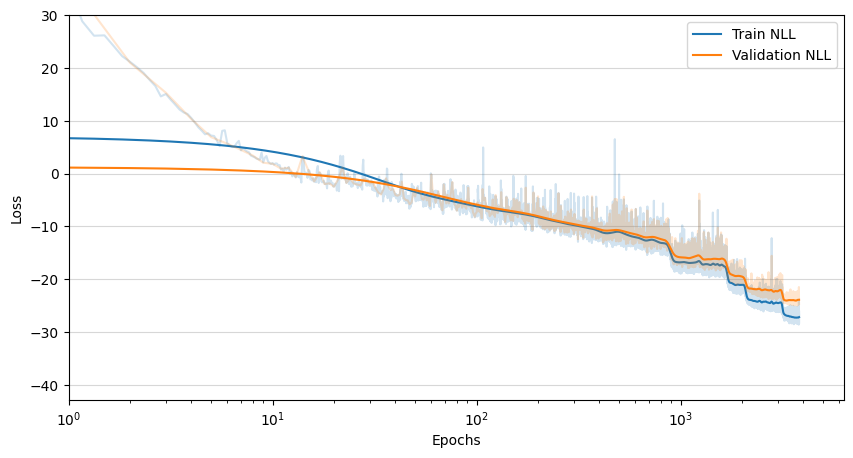

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

epochs = np.array([e for e, _ in loss_history['train']])
losses = np.array([l for _, l in loss_history['train']])

ax.plot(epochs, losses, alpha=0.2, color='C0')
ax.plot(epochs, partconv1d(losses, kernel=get_gaussian_kernel(sigma=128)), label='Train NLL', color='C0')

epochs = np.array([e for e, _ in loss_history['val']])
losses = np.array([l for _, l in loss_history['val']])

ax.plot(epochs, losses, alpha=0.2, color='C1')
ax.plot(epochs, partconv1d(losses, kernel=get_gaussian_kernel(sigma=32)), label='Validation NLL', color='C1')

ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

ax.set_xscale('log')
ax.set_ylim(None, 30)
ax.set_xlim(1, None)
ax.grid(axis='y', alpha=0.5)

ax.legend();